
[Avg sentence length ↔ overall_score] — TRAIN correlation matrix:
                              pr_avg_sentence_len  resp_avg_sentence_len  \
pr_avg_sentence_len                         1.000                  0.083   
resp_avg_sentence_len                       0.083                  1.000   
resp_to_pr_avg_sentlen_ratio               -0.211                  0.785   
overall_score                              -0.006                  0.195   

                              resp_to_pr_avg_sentlen_ratio  overall_score  
pr_avg_sentence_len                                 -0.211         -0.006  
resp_avg_sentence_len                                0.785          0.195  
resp_to_pr_avg_sentlen_ratio                         1.000          0.165  
overall_score                                        0.165          1.000  

[Avg sentence length ↔ overall_score] — VALIDATION correlation matrix:
                              pr_avg_sentence_len  resp_avg_sentence_len  \
pr_avg_sentence_len     

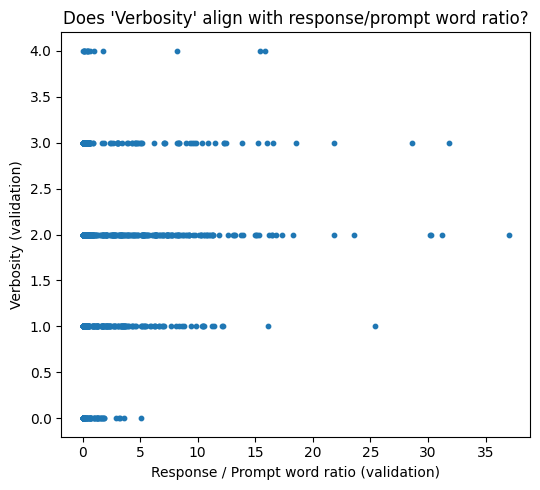

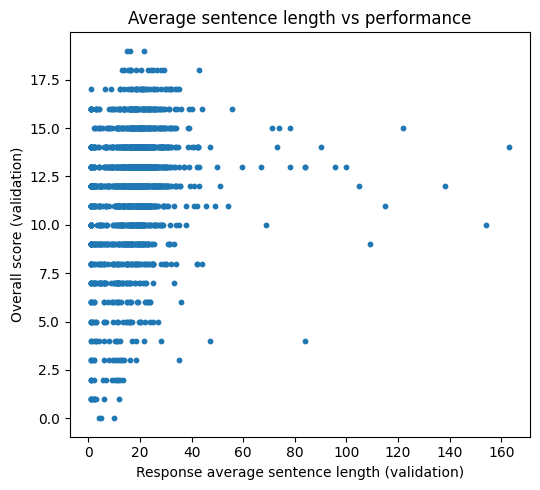


Prediction clamp bounds (from TRAIN): [4.000, 24.995]  (mu=11.904, sd=3.273)

VALIDATION metrics (RidgeCV, engineered-only, bounded):
R^2:  0.1927
MAE:  2.2343
RMSE: 2.8828
Saved predictions: predictions_validation_bounded.csv


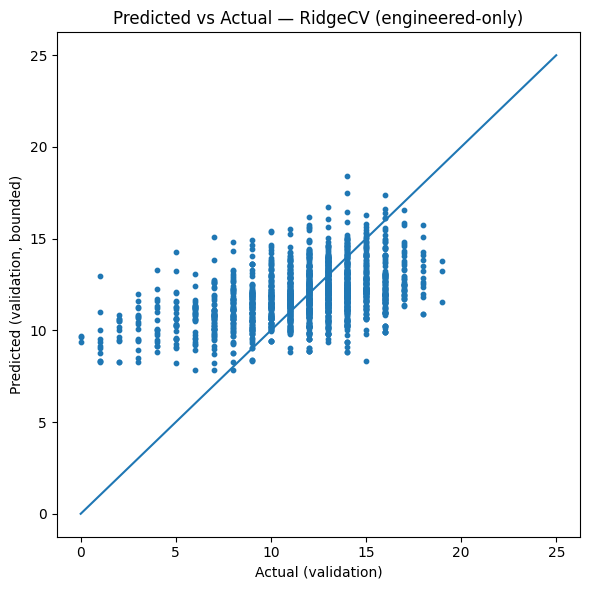


Top engineered features by |corr| with overall_score (TRAIN):
resp_char_len                   0.399
resp_word_count                 0.386
resp_verb_count                 0.340
resp_to_pr_char_ratio           0.197
resp_to_pr_word_ratio           0.195
resp_avg_sentence_len           0.195
pr_to_resp_len_ratio           -0.174
resp_to_pr_avg_sentlen_ratio    0.165
resp_verb_ratio                 0.135
pr_avg_word_len                 0.077
resp_avg_word_len               0.076
pr_verb_ratio                   0.024
pr_char_len                     0.022
pr_word_count                   0.014
pr_verb_count                   0.013
dtype: float64


In [1]:
# === Full pipeline: feature engineering + model + "verbosity alignment" analysis ===
# - Builds average sentence length & verbosity proxies from prompt/response
# - Fits RidgeCV with ONLY engineered text features (no leakage from the five subscores)
# - Clamps predictions to μ ± 4σ (floor=4.0) from TRAIN
# - Compares 'verbosity' score to response/prompt ratios (does the rubric align with measured verbosity?)
# - Saves CSVs and produces plots
import os, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
ALPHAS = np.logspace(-3, 3, 25)
SIGMA_MULT = 4.0    # clamp preds to μ ± 4σ (from TRAIN)
FLOOR = 4.0         # do not predict below this
SAVE_PREFIX = ""    # optionally set like "exp1_" to prefix outputs

# ---------------- 0) Load TRAIN + VALIDATION, compute overall_score ----------------
COMPONENTS = ["helpfulness","correctness","coherence","complexity","verbosity"]
TARGET = "overall_score"

if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No `df` in memory and no train.csv found.")

# Ensure needed cols
miss = [c for c in COMPONENTS if c not in df.columns]
if miss: raise KeyError(f"Train DF missing columns: {miss}")
df[TARGET] = df[COMPONENTS].sum(axis=1, min_count=1)

if not os.path.exists("validation.csv"):
    raise FileNotFoundError("validation.csv not found.")
df_val = pd.read_csv("validation.csv")
miss_v = [c for c in COMPONENTS if c not in df_val.columns]
if miss_v: raise KeyError(f"Validation DF missing columns: {miss_v}")
df_val[TARGET] = df_val[COMPONENTS].sum(axis=1, min_count=1)

# ---------------- 1) Column detection ----------------
def _guess(df0, cands):
    lower = {c.lower(): c for c in df0.columns}
    for k in cands:
        if k.lower() in lower: return lower[k.lower()]
    return None

prompt_col  = _guess(df,     ["prompt","instruction","input","question"])
response_col= _guess(df,     ["response","output","answer","completion"])
if prompt_col is None or response_col is None:
    raise KeyError("Could not detect prompt/response in TRAIN.")

prompt_col_val  = prompt_col if prompt_col in df_val.columns else _guess(df_val, ["prompt","instruction","input","question"])
response_col_val= response_col if response_col in df_val.columns else _guess(df_val, ["response","output","answer","completion"])
if prompt_col_val is None or response_col_val is None:
    raise KeyError("Could not detect prompt/response in VALIDATION.")

# ---------------- 2) Lightweight NLP utilities (no external libs) ----------------
_token_re = re.compile(r"[A-Za-z0-9']+")
_sentence_split_re = re.compile(r"(?<=[.!?])\s+")

def _tokens(x):
    return _token_re.findall(str(x).lower()) if isinstance(x,str) else []

def _word_count(x): 
    return len(_tokens(x))

def _char_len(x):
    return len(str(x)) if isinstance(x,str) else 0

def _avg_word_len(x):
    t = _tokens(x)
    return float(np.mean([len(w) for w in t])) if t else np.nan

def _avg_sentence_len(x):
    # average number of words per sentence (rough split on . ! ?)
    if not isinstance(x,str) or not x.strip():
        return np.nan
    sents = re.split(_sentence_split_re, x.strip())
    sents = [s for s in sents if _word_count(s) > 0]
    if not sents: return np.nan
    return float(np.mean([_word_count(s) for s in sents]))

def _verb_count(x):
    # heuristic: auxiliaries + -ed/-ing endings
    if not isinstance(x,str): return 0
    t = _tokens(x)
    auxiliaries = {"be","am","is","are","was","were","been","being","do","does","did","have","has","had",
                   "will","would","shall","should","can","could","may","might","must"}
    cnt = 0
    for w in t:
        if w in auxiliaries or (len(w) > 3 and (w.endswith("ed") or w.endswith("ing"))):
            cnt += 1
    return cnt

def _safe_div(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

# ---------------- 3) Feature engineering for one DF ----------------
def build_features(df0, prompt_col, response_col, prefix=""):
    pr = df0[prompt_col].fillna("")
    rs = df0[response_col].fillna("")
    feats = pd.DataFrame(index=df0.index)

    # Prompt features
    feats[f"{prefix}pr_word_count"]        = pr.map(_word_count).astype("float32")
    feats[f"{prefix}pr_char_len"]          = pr.map(_char_len).astype("float32")
    feats[f"{prefix}pr_avg_word_len"]      = pr.map(_avg_word_len).astype("float32")
    feats[f"{prefix}pr_avg_sentence_len"]  = pr.map(_avg_sentence_len).astype("float32")
    feats[f"{prefix}pr_verb_count"]        = pr.map(_verb_count).astype("float32")
    feats[f"{prefix}pr_verb_ratio"]        = _safe_div(feats[f"{prefix}pr_verb_count"], feats[f"{prefix}pr_word_count"])

    # Response features
    feats[f"{prefix}resp_word_count"]        = rs.map(_word_count).astype("float32")
    feats[f"{prefix}resp_char_len"]          = rs.map(_char_len).astype("float32")
    feats[f"{prefix}resp_avg_word_len"]      = rs.map(_avg_word_len).astype("float32")
    feats[f"{prefix}resp_avg_sentence_len"]  = rs.map(_avg_sentence_len).astype("float32")
    feats[f"{prefix}resp_verb_count"]        = rs.map(_verb_count).astype("float32")
    feats[f"{prefix}resp_verb_ratio"]        = _safe_div(feats[f"{prefix}resp_verb_count"], feats[f"{prefix}resp_word_count"])

    # "Verbosity" proxies (response relative to prompt)
    feats[f"{prefix}resp_to_pr_word_ratio"]       = _safe_div(feats[f"{prefix}resp_word_count"], feats[f"{prefix}pr_word_count"])
    feats[f"{prefix}resp_to_pr_char_ratio"]       = _safe_div(feats[f"{prefix}resp_char_len"],   feats[f"{prefix}pr_char_len"])
    feats[f"{prefix}resp_to_pr_avg_sentlen_ratio"]= _safe_div(feats[f"{prefix}resp_avg_sentence_len"], feats[f"{prefix}pr_avg_sentence_len"])

    # Backward-compatible name, if you’ve used it elsewhere:
    feats[f"{prefix}pr_to_resp_len_ratio"] = _safe_div(feats[f"{prefix}pr_word_count"], feats[f"{prefix}resp_word_count"])

    return feats

feat_train = build_features(df, prompt_col, response_col)
feat_val   = build_features(df_val, prompt_col_val, response_col_val)

# Combine features to the original frames (helps for corr calcs)
df_train_full = pd.concat([df.reset_index(drop=True),     feat_train.reset_index(drop=True)], axis=1)
df_val_full   = pd.concat([df_val.reset_index(drop=True), feat_val.reset_index(drop=True)],   axis=1)

# ---------------- 4) Correlation analyses: average sentence vs performance; verbosity alignment ----------------
def corr_df(frame, cols, method="pearson"):
    return frame[cols].corr(method=method, numeric_only=True)

# (A) How average sentence length relates to performance
avg_sentence_cols = [
    "pr_avg_sentence_len", "resp_avg_sentence_len", "resp_to_pr_avg_sentlen_ratio"
]
cols_train_as = avg_sentence_cols + [TARGET]
cols_val_as   = avg_sentence_cols + [TARGET]
corr_train_as = corr_df(df_train_full, cols_train_as)
corr_val_as   = corr_df(df_val_full,   cols_val_as)
corr_train_as.to_csv(SAVE_PREFIX+"avg_sentence_performance_correlations_train.csv")
corr_val_as.to_csv(SAVE_PREFIX+"avg_sentence_performance_correlations_val.csv")

print("\n[Avg sentence length ↔ overall_score] — TRAIN correlation matrix:")
print(corr_train_as.round(3))
print("\n[Avg sentence length ↔ overall_score] — VALIDATION correlation matrix:")
print(corr_val_as.round(3))

# (B) Does 'verbosity' align with actual verbosity proxies?
verbosity_proxy_cols = [
    "resp_to_pr_word_ratio", "resp_to_pr_char_ratio", "resp_to_pr_avg_sentlen_ratio",
    "resp_word_count", "pr_word_count"  # extras for context
]
cols_train_v = ["verbosity"] + verbosity_proxy_cols
cols_val_v   = ["verbosity"] + verbosity_proxy_cols
corr_train_v = corr_df(df_train_full, cols_train_v)
corr_val_v   = corr_df(df_val_full,   cols_val_v)
corr_train_v.to_csv(SAVE_PREFIX+"verbosity_alignment_correlations_train.csv")
corr_val_v.to_csv(SAVE_PREFIX+"verbosity_alignment_correlations_val.csv")

print("\n[Verbosity ↔ proxies] — TRAIN correlation matrix:")
print(corr_train_v.round(3))
print("\n[Verbosity ↔ proxies] — VALIDATION correlation matrix:")
print(corr_val_v.round(3))

# Quick scatter: verbosity vs response/prompt word ratio (validation)
plt.figure(figsize=(5.5,5))
x = df_val_full["resp_to_pr_word_ratio"].astype(float)
y = df_val_full["verbosity"].astype(float)
m = np.isfinite(x) & np.isfinite(y)
plt.scatter(x[m], y[m], s=10)
plt.xlabel("Response / Prompt word ratio (validation)")
plt.ylabel("Verbosity (validation)")
plt.title("Does 'Verbosity' align with response/prompt word ratio?")
plt.tight_layout(); plt.show()

# Quick scatter: resp_avg_sentence_len vs overall_score (validation)
plt.figure(figsize=(5.5,5))
x2 = df_val_full["resp_avg_sentence_len"].astype(float)
y2 = df_val_full[TARGET].astype(float)
m2 = np.isfinite(x2) & np.isfinite(y2)
plt.scatter(x2[m2], y2[m2], s=10)
plt.xlabel("Response average sentence length (validation)")
plt.ylabel("Overall score (validation)")
plt.title("Average sentence length vs performance")
plt.tight_layout(); plt.show()

# ---------------- 5) Modeling — leakage-free RidgeCV (engineered only) ----------------
# Build the model features (no COMPONENTS in X to avoid leakage)
model_feats = [c for c in feat_train.columns]  # all engineered features we built above

# Align train arrays
y_tr = pd.to_numeric(df_train_full[TARGET], errors="coerce")
X_tr = df_train_full[model_feats].apply(pd.to_numeric, errors="coerce")
mask_tr = y_tr.notna()
y_tr = y_tr.loc[mask_tr].reset_index(drop=True)
X_tr = X_tr.loc[mask_tr].reset_index(drop=True)

# Fit model
pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=True, with_std=True)),
    ("ridge",  RidgeCV(alphas=ALPHAS))
])
pipe.fit(X_tr, y_tr)

# Validation arrays (align columns/order; create missing cols if needed)
for c in model_feats:
    if c not in df_val_full.columns:
        df_val_full[c] = np.nan
X_val = df_val_full[model_feats].apply(pd.to_numeric, errors="coerce")
y_val = pd.to_numeric(df_val_full[TARGET], errors="coerce")
mask_val = y_val.notna()
X_val = X_val.loc[mask_val].reset_index(drop=True)
y_val = y_val.loc[mask_val].reset_index(drop=True)

# Clamp to μ ± 4σ (floor 4.0) from TRAIN target distribution
mu = float(np.nanmean(y_tr)); sd = float(np.nanstd(y_tr, ddof=0))
lower = max(FLOOR, mu - SIGMA_MULT*sd); upper = mu + SIGMA_MULT*sd
print(f"\nPrediction clamp bounds (from TRAIN): [{lower:.3f}, {upper:.3f}]  (mu={mu:.3f}, sd={sd:.3f})")

y_val_pred_raw = pipe.predict(X_val)
y_val_pred = np.clip(y_val_pred_raw, lower, upper)

# Metrics
def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

r2  = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
rmse= _rmse(y_val, y_val_pred)

print("\nVALIDATION metrics (RidgeCV, engineered-only, bounded):")
print(f"R^2:  {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Save artifacts
pred_path = SAVE_PREFIX+"predictions_validation_bounded.csv"
pd.DataFrame({"y_true": y_val.values, "y_pred": y_val_pred}).to_csv(pred_path, index=False)
print(f"Saved predictions: {pred_path}")

try:
    import joblib
    joblib.dump(pipe, SAVE_PREFIX+"ridge_pipeline.joblib")
except Exception as e:
    print("Warning: could not save model pipeline:", e)

# Plot Pred vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, s=10)
mn = float(min(y_val.min(), lower)); mx = float(max(y_val.max(), upper))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual (validation)")
plt.ylabel("Predicted (validation, bounded)")
plt.title("Predicted vs Actual — RidgeCV (engineered-only)")
plt.tight_layout(); plt.show()

# ---------------- 6) (Optional) sanity print: top correlations driving performance ----------------
# Pearson corr of engineered features vs target (TRAIN)
corrs = {}
for c in model_feats:
    a = pd.to_numeric(df_train_full[c], errors="coerce")
    b = y_tr
    m = a.notna() & b.notna()
    if m.sum() >= 3:
        corrs[c] = np.corrcoef(a[m], b[m])[0,1]
corr_series = pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)
print("\nTop engineered features by |corr| with overall_score (TRAIN):")
print(corr_series.head(15).round(3))


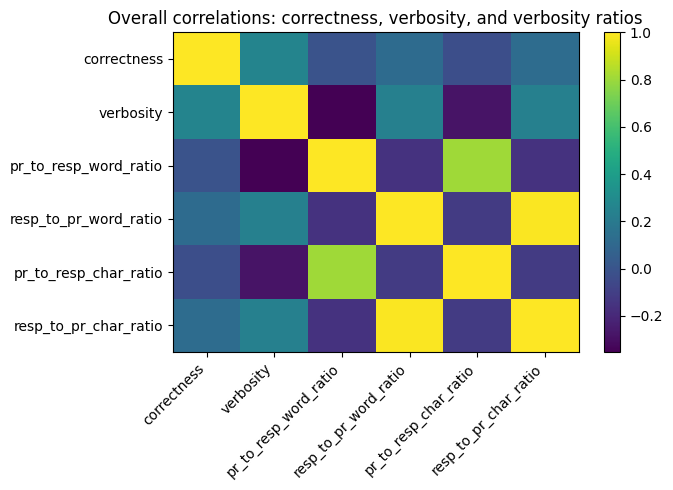

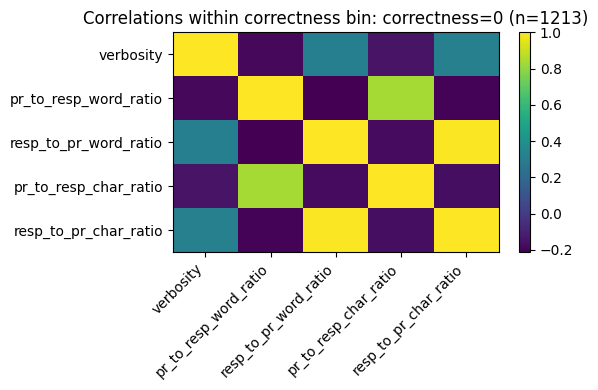

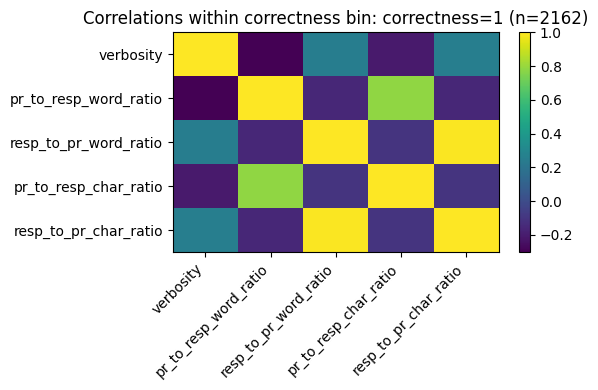

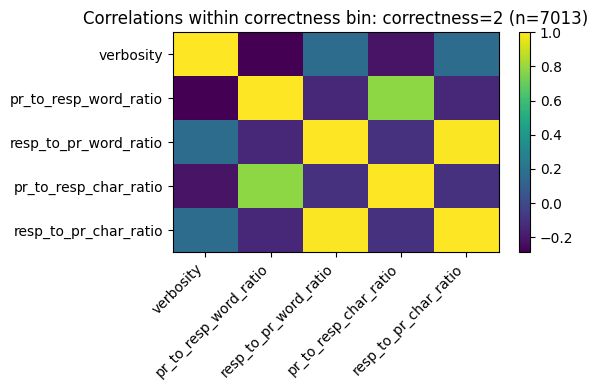

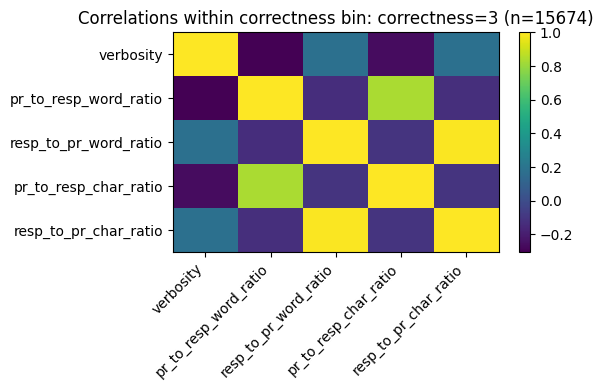

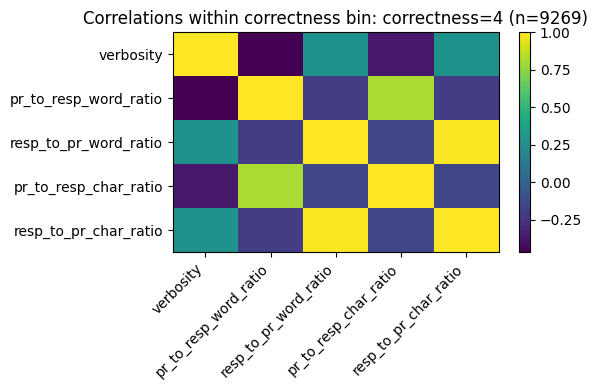


Per-bin means (verbosity and ratios by correctness level):
          bin     n  mean_correctness  mean_verbosity  mean_pr_to_resp_word_ratio  mean_resp_to_pr_word_ratio  mean_pr_to_resp_char_ratio  mean_resp_to_pr_char_ratio
correctness=0  1213            0.0000          0.4782                    100.0858                      0.4089                    129.5519                      0.4164
correctness=1  2162            1.0000          0.9981                     73.4979                      0.7201                     94.7250                      0.7412
correctness=2  7013            2.0000          1.3960                     42.0917                      1.0254                     47.8369                      1.0819
correctness=3 15674            3.0000          1.6737                     30.7270                      1.4735                     30.7829                      1.5762
correctness=4  9269            4.0000          1.6675                     72.8876                      1.9350 

In [3]:
# === Correlation study: correctness as target; compare verbosity vs prompt/response ratios ===
# Outputs:
#   - Printed summary table
#   - CSV: correctness_verbosity_ratio_correlations.csv
import os, re, numpy as np, pandas as pd

# ---------------- Load training data ----------------
# Use in-memory df if present, else try train.csv
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No DataFrame `df` and no train.csv found.")

# ---------------- Basic checks ----------------
required = ["helpfulness","correctness","coherence","complexity","verbosity"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Train DF missing required columns: {missing}")

# ---------------- Column detection for prompt/response ----------------
def _guess(df0, cands):
    m = {c.lower(): c for c in df0.columns}
    for k in cands:
        if k.lower() in m: 
            return m[k.lower()]
    return None

prompt_col  = _guess(df, ["prompt","instruction","input","question"])
response_col= _guess(df, ["response","output","answer","completion"])
if prompt_col is None or response_col is None:
    raise KeyError("Could not detect `prompt`/`response` columns. Please ensure they exist (or rename).")

# ---------------- Lightweight tokenization + feature helpers ----------------
_token_re = re.compile(r"[A-Za-z0-9']+")
def _tokens(x): 
    return _token_re.findall(str(x).lower()) if isinstance(x,str) else []

def _word_count(x): 
    return len(_tokens(x))

def _char_len(x): 
    return len(str(x)) if isinstance(x,str) else 0

def _safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

def _pearson(a, b):
    a = pd.to_numeric(pd.Series(a), errors="coerce")
    b = pd.to_numeric(pd.Series(b), errors="coerce")
    m = a.notna() & b.notna()
    if m.sum() < 3:
        return np.nan
    return float(np.corrcoef(a[m], b[m])[0,1])

# ---------------- Build the needed features ----------------
pr_text = df[prompt_col].fillna("")
rs_text = df[response_col].fillna("")

# Word/char counts
df_feats = pd.DataFrame(index=df.index)
df_feats["pr_word_count"]   = pr_text.map(_word_count).astype(float)
df_feats["resp_word_count"] = rs_text.map(_word_count).astype(float)
df_feats["pr_char_len"]     = pr_text.map(_char_len).astype(float)
df_feats["resp_char_len"]   = rs_text.map(_char_len).astype(float)

# Ratios (both directions)
df_feats["pr_to_resp_word_ratio"]  = _safe_div(df_feats["pr_word_count"],  df_feats["resp_word_count"])
df_feats["resp_to_pr_word_ratio"]  = _safe_div(df_feats["resp_word_count"], df_feats["pr_word_count"])
df_feats["pr_to_resp_char_ratio"]  = _safe_div(df_feats["pr_char_len"],    df_feats["resp_char_len"])
df_feats["resp_to_pr_char_ratio"]  = _safe_div(df_feats["resp_char_len"],  df_feats["pr_char_len"])

# Attach target + verbosity for correlation calcs
df_feats["correctness"] = pd.to_numeric(df["correctness"], errors="coerce")
df_feats["verbosity"]   = pd.to_numeric(df["verbosity"],   errors="coerce")

# ---------------- Correlation calculations ----------------
base_corr = _pearson(df_feats["correctness"], df_feats["verbosity"])  # corr(correctness, verbosity)

ratios = [
    ("pr_to_resp_word_ratio", "words (prompt/response)"),
    ("resp_to_pr_word_ratio", "words (response/prompt)"),
    ("pr_to_resp_char_ratio", "chars (prompt/response)"),
    ("resp_to_pr_char_ratio", "chars (response/prompt)"),
]

rows = []
for col, desc in ratios:
    corr_corr_ratio = _pearson(df_feats["correctness"], df_feats[col])
    corr_verb_ratio = _pearson(df_feats["verbosity"],   df_feats[col])
    gap_vs_verbosity = base_corr - corr_corr_ratio  # positive => verbosity correlates more with correctness than this ratio does
    rows.append({
        "ratio_feature": col,
        "description": desc,
        "corr(correctness, verbosity)": base_corr,
        f"corr(correctness, {col})": corr_corr_ratio,
        "gap: corr(correctness,verbosity) - corr(correctness,ratio)": gap_vs_verbosity,
        f"corr(verbosity, {col})": corr_verb_ratio,
    })
# === Correlation heatmaps & stratified-by-correctness analysis ===
# - Computes verbosity/ratio features from prompt & response
# - Overall correlation heatmap for: correctness, verbosity, ratios
# - Stratifies by correctness (int levels or 5-quantile bins) and plots per-bin heatmaps
# - Robust "safe" correlation to avoid NaNs (Pearson -> Spearman ranks -> 0.0)
# - Saves CSVs for auditability

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------------- Load train data ----------------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No DataFrame `df` in memory and no train.csv found.")

required = ["helpfulness","correctness","coherence","complexity","verbosity"]
miss = [c for c in required if c not in df.columns]
if miss:
    raise KeyError(f"Train DF missing required columns: {miss}")

# ---------------- Detect prompt/response ----------------
def _guess(df0, cands):
    m = {c.lower(): c for c in df0.columns}
    for k in cands:
        if k.lower() in m:
            return m[k.lower()]
    return None

prompt_col  = _guess(df, ["prompt","instruction","input","question"])
response_col= _guess(df, ["response","output","answer","completion"])
if prompt_col is None or response_col is None:
    raise KeyError("Could not detect `prompt`/`response` columns.")

# ---------------- Lightweight tokenization & helpers ----------------
_token_re = re.compile(r"[A-Za-z0-9']+")

def _tokens(x):
    return _token_re.findall(str(x).lower()) if isinstance(x,str) else []

def _word_count(x):
    return len(_tokens(x))

def _char_len(x):
    return len(str(x)) if isinstance(x,str) else 0

def _safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b
        z[~np.isfinite(z)] = np.nan
    return z

# ---------------- Build verbosity/ratio features ----------------
pr = df[prompt_col].fillna("")
rs = df[response_col].fillna("")

feat = pd.DataFrame(index=df.index)
feat["pr_word_count"]   = pr.map(_word_count).astype(float)
feat["resp_word_count"] = rs.map(_word_count).astype(float)
feat["pr_char_len"]     = pr.map(_char_len).astype(float)
feat["resp_char_len"]   = rs.map(_char_len).astype(float)

# Ratios both directions
feat["pr_to_resp_word_ratio"]  = _safe_div(feat["pr_word_count"],  feat["resp_word_count"])
feat["resp_to_pr_word_ratio"]  = _safe_div(feat["resp_word_count"], feat["pr_word_count"])
feat["pr_to_resp_char_ratio"]  = _safe_div(feat["pr_char_len"],    feat["resp_char_len"])
feat["resp_to_pr_char_ratio"]  = _safe_div(feat["resp_char_len"],  feat["pr_char_len"])

# Attach needed targets/labels
feat["correctness"] = pd.to_numeric(df["correctness"], errors="coerce")
feat["verbosity"]   = pd.to_numeric(df["verbosity"],   errors="coerce")

# ---------------- Safe correlation utilities ----------------
def _pearson_safe(x, y):
    """Pearson with pairwise complete obs; returns np.nan if <3 points."""
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    y = pd.to_numeric(pd.Series(y), errors="coerce")
    m = x.notna() & y.notna()
    if m.sum() < 3:
        return np.nan
    xv = x[m].values
    yv = y[m].values
    # if constant variance -> pearson undefined
    if np.allclose(xv, xv[0]) or np.allclose(yv, yv[0]):
        return np.nan
    return float(np.corrcoef(xv, yv)[0, 1])

def _spearman_rank_safe(x, y):
    """Spearman via rank transform; returns np.nan if <3 or constant."""
    x = pd.to_numeric(pd.Series(x), errors="coerce")
    y = pd.to_numeric(pd.Series(y), errors="coerce")
    m = x.notna() & y.notna()
    if m.sum() < 3:
        return np.nan
    xr = x[m].rank(method="average")
    yr = y[m].rank(method="average")
    if xr.nunique() < 2 or yr.nunique() < 2:
        return np.nan
    return float(np.corrcoef(xr, yr)[0, 1])

def corr_safe(a, b):
    """Pearson; fallback to Spearman ranks; final fallback 0.0."""
    r = _pearson_safe(a, b)
    if np.isnan(r):
        r = _spearman_rank_safe(a, b)
    if np.isnan(r):
        r = 0.0
    return r

def corr_matrix_safe(frame, cols):
    mat = np.zeros((len(cols), len(cols)), dtype=float)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if i == j:
                mat[i, j] = 1.0
            else:
                mat[i, j] = corr_safe(frame[c1], frame[c2])
    return pd.DataFrame(mat, index=cols, columns=cols)

# ---------------- Overall correlation heatmap ----------------
overall_cols = [
    "correctness", "verbosity",
    "pr_to_resp_word_ratio", "resp_to_pr_word_ratio",
    "pr_to_resp_char_ratio", "resp_to_pr_char_ratio"
]
overall_corr = corr_matrix_safe(feat, overall_cols)
overall_corr.to_csv("overall_corr_matrix.csv", index=True)

# Plot heatmap (matplotlib only; no explicit color choice)
plt.figure(figsize=(7, 5))
plt.imshow(overall_corr.values, aspect="auto")
plt.xticks(range(len(overall_cols)), overall_cols, rotation=45, ha="right")
plt.yticks(range(len(overall_cols)), overall_cols)
plt.colorbar()
plt.title("Overall correlations: correctness, verbosity, and verbosity ratios")
plt.tight_layout()
plt.show()

# ---------------- Stratify by correctness level ----------------
# Strategy: if correctness has <=10 unique integer values, use them as levels.
# Otherwise, build 5 quantile bins.
corr_vals = pd.to_numeric(feat["correctness"], errors="coerce")
uniq = pd.unique(corr_vals.dropna())
use_int_levels = False
if len(uniq) <= 10 and np.all(np.equal(np.mod(uniq, 1), 0)):  # all ints and few levels
    use_int_levels = True

if use_int_levels:
    feat["correctness_bin"] = corr_vals
    bin_labels = sorted(pd.unique(feat["correctness_bin"].dropna()))
else:
    # 5 quantile bins with labels like Q1..Q5 plus ranges in printout
    feat["correctness_bin"] = pd.qcut(corr_vals, q=5, duplicates="drop")
    bin_labels = feat["correctness_bin"].dropna().unique().tolist()

ratio_cols = [
    "pr_to_resp_word_ratio", "resp_to_pr_word_ratio",
    "pr_to_resp_char_ratio", "resp_to_pr_char_ratio"
]
per_bin_summary = []

# Per-bin heatmaps: correlations among [verbosity] + ratio features
for bl in bin_labels:
    if use_int_levels:
        mask = feat["correctness_bin"] == bl
        bin_name = f"correctness={int(bl)}"
    else:
        mask = feat["correctness_bin"] == bl
        # bin "bl" is a pandas Interval; add a readable label
        bin_name = f"{bl.left:.2f}–{bl.right:.2f}"

    sub = feat.loc[mask].copy()
    # compute per-bin means for summary
    row = {
        "bin": bin_name,
        "n": int(mask.sum()),
        "mean_correctness": float(np.nanmean(sub["correctness"])) if mask.sum() > 0 else np.nan,
        "mean_verbosity":   float(np.nanmean(sub["verbosity"]))   if mask.sum() > 0 else np.nan,
    }
    for rc in ratio_cols:
        row[f"mean_{rc}"] = float(np.nanmean(sub[rc])) if mask.sum() > 0 else np.nan
    per_bin_summary.append(row)

    # Heatmap variables (verbosity + ratios)
    bin_cols = ["verbosity"] + ratio_cols
    bin_corr = corr_matrix_safe(sub, bin_cols)
    # save CSV
    safe_tag = str(bl).replace(" ", "").replace("(", "").replace(")", "").replace(",", "_").replace("]", "").replace("[", "")
    csv_path = f"corr_bin_{safe_tag}.csv"
    bin_corr.to_csv(csv_path, index=True)

    # plot heatmap
    plt.figure(figsize=(6, 4))
    plt.imshow(bin_corr.values, aspect="auto")
    plt.xticks(range(len(bin_cols)), bin_cols, rotation=45, ha="right")
    plt.yticks(range(len(bin_cols)), bin_cols)
    plt.colorbar()
    plt.title(f"Correlations within correctness bin: {bin_name} (n={int(mask.sum())})")
    plt.tight_layout()
    plt.show()

# ---------------- Per-bin summary table (means) ----------------
summary_df = pd.DataFrame(per_bin_summary)
summary_df.to_csv("summary_by_correctness_bin.csv", index=False)
print("\nPer-bin means (verbosity and ratios by correctness level):")
pd.set_option("display.float_format", lambda v: f"{v:0.4f}")
print(summary_df.to_string(index=False))

summary = pd.DataFrame(rows)

# ---------------- Print and save ----------------
pd.set_option("display.float_format", lambda v: f"{v:0.4f}")
print("Target = correctness\n")
print(summary.to_string(index=False))

out_path = "correctness_verbosity_ratio_correlations.csv"
summary.to_csv(out_path, index=False)
print(f"\nSaved: {out_path}")

# ---------------- (Optional) Small note on interpretation ----------------
# - 'corr(correctness, verbosity)': how strongly the human 'verbosity' score aligns with correctness.
# - 'corr(correctness, <ratio>)': how strongly raw length/char ratios align with correctness.
# - 'gap' = if positive, correctness aligns more with 'verbosity' than with that ratio; if negative, the ratio aligns more.
# - 'corr(verbosity, <ratio>)': whether the human 'verbosity' score matches measurable verbosity proxies.


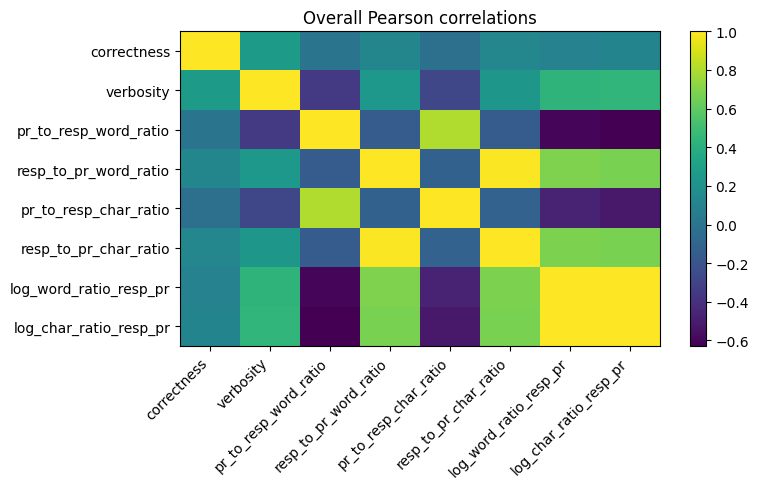

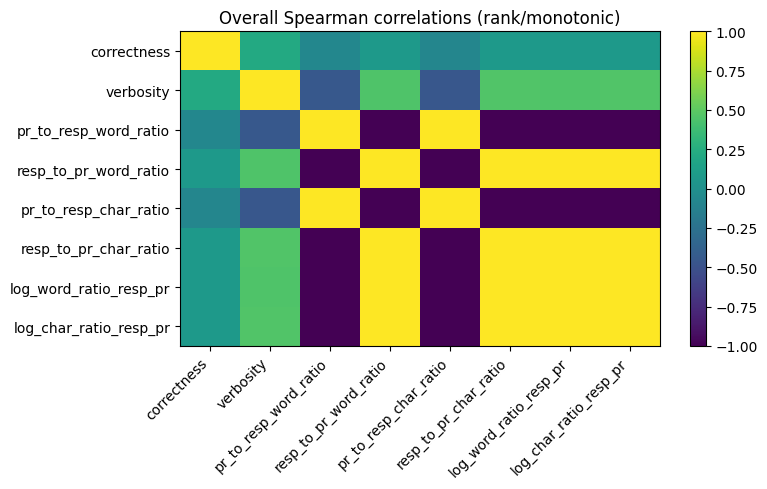


Top partial correlations (Verbosity vs Ratios):
                   partial_corr_of                controls       r
verbosity ~ log_char_ratio_resp_pr     control=correctness  0.4310
verbosity ~ log_word_ratio_resp_pr     control=correctness  0.4260
 verbosity ~ resp_to_pr_word_ratio     control=correctness  0.2149
 verbosity ~ resp_to_pr_char_ratio     control=correctness  0.2119
verbosity ~ log_char_ratio_resp_pr control=correctness+len  0.2102
verbosity ~ log_word_ratio_resp_pr control=correctness+len  0.2051
 verbosity ~ resp_to_pr_char_ratio control=correctness+len -0.0076
 verbosity ~ resp_to_pr_word_ratio control=correctness+len -0.0086
verbosity ~ log_char_ratio_resp_pr         control=lengths  0.2137
verbosity ~ log_word_ratio_resp_pr         control=lengths  0.2057
 verbosity ~ resp_to_pr_char_ratio         control=lengths  0.0105
 verbosity ~ resp_to_pr_word_ratio         control=lengths  0.0093


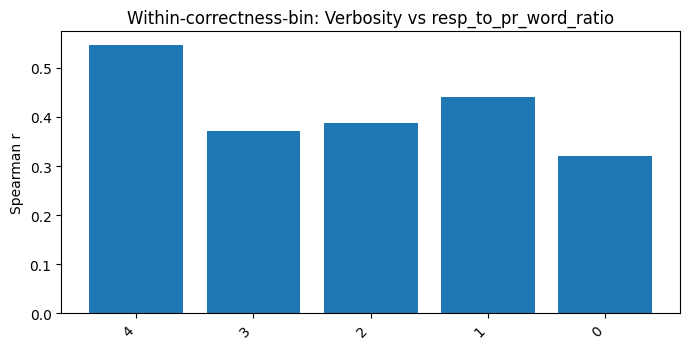

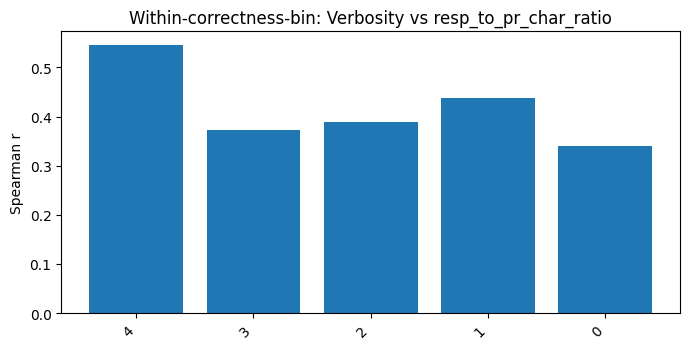


Model A: correctness ~ verbosity + log ratios
R^2: 0.0762
Std coeffs: {'verbosity': 0.25248139852934154, 'log_word_ratio_resp_pr': -1.1123431476612455, 'log_char_ratio_resp_pr': 1.0992243269276032}

Model B: verbosity ~ log ratios
R^2: 0.1978
Std coeffs: {'log_word_ratio_resp_pr': -0.5945486866331162, 'log_char_ratio_resp_pr': 1.0019834036629505}


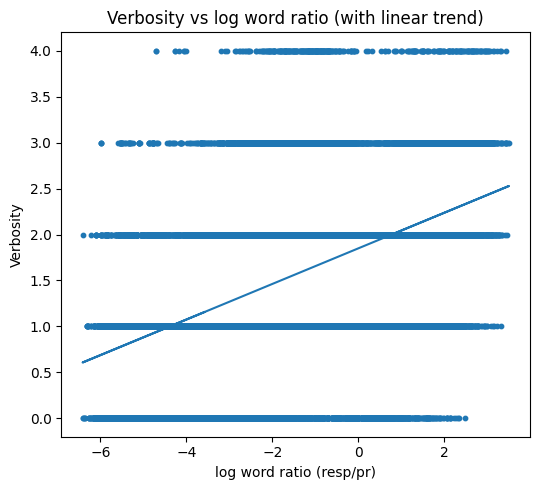


Saved files:
  - overall_pearson_corr.csv / overall_spearman_corr.csv
  - partial_correlations_verbosity_vs_ratios.csv
  - bin_spearman_verbosity_vs_ratios.csv


In [4]:
# === Deep dive on Verbosity vs. length proxies, with partial correlations & binning ===
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---------------- Load data ----------------
if 'df' not in globals():
    if os.path.exists("train.csv"):
        df = pd.read_csv("train.csv")
    else:
        raise FileNotFoundError("No DataFrame `df` and no train.csv found.")

needed = ["helpfulness","correctness","coherence","complexity","verbosity"]
miss = [c for c in needed if c not in df.columns]
if miss: raise KeyError(f"Train DF missing: {miss}")

# ---------------- Detect prompt/response ----------------
def _guess(d, cands):
    m = {c.lower(): c for c in d.columns}
    for k in cands:
        if k.lower() in m: return m[k.lower()]
    return None

prompt_col  = _guess(df, ["prompt","instruction","input","question"])
response_col= _guess(df, ["response","output","answer","completion"])
if prompt_col is None or response_col is None:
    raise KeyError("Could not find prompt/response columns.")

# ---------------- Lite NLP helpers ----------------
_token_re = re.compile(r"[A-Za-z0-9']+")
def _tokens(x): return _token_re.findall(str(x).lower()) if isinstance(x,str) else []
def _wc(x):     return len(_tokens(x))
def _cl(x):     return len(str(x)) if isinstance(x,str) else 0
def _safe_div(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        z = a / b; z[~np.isfinite(z)] = np.nan
    return z

# ---------------- Build features ----------------
pr = df[prompt_col].fillna("")
rs = df[response_col].fillna("")
feat = pd.DataFrame(index=df.index)
feat["pr_word_count"]   = pr.map(_wc).astype(float)
feat["resp_word_count"] = rs.map(_wc).astype(float)
feat["pr_char_len"]     = pr.map(_cl).astype(float)
feat["resp_char_len"]   = rs.map(_cl).astype(float)

# Ratios in both directions
feat["pr_to_resp_word_ratio"] = _safe_div(feat["pr_word_count"],  feat["resp_word_count"])
feat["resp_to_pr_word_ratio"] = _safe_div(feat["resp_word_count"], feat["pr_word_count"])
feat["pr_to_resp_char_ratio"] = _safe_div(feat["pr_char_len"],    feat["resp_char_len"])
feat["resp_to_pr_char_ratio"] = _safe_div(feat["resp_char_len"],  feat["pr_char_len"])

# Log-stable versions (log1p counts → differences = log ratios)
feat["log_word_ratio_resp_pr"] = np.log1p(feat["resp_word_count"]) - np.log1p(feat["pr_word_count"])
feat["log_char_ratio_resp_pr"] = np.log1p(feat["resp_char_len"])   - np.log1p(feat["pr_char_len"])

# Add labels
feat["correctness"] = pd.to_numeric(df["correctness"], errors="coerce")
feat["verbosity"]   = pd.to_numeric(df["verbosity"],   errors="coerce")

# ---------------- Correlation helpers ----------------
def _pearson_safe(a, b):
    a = pd.to_numeric(pd.Series(a), errors="coerce"); b = pd.to_numeric(pd.Series(b), errors="coerce")
    m = a.notna() & b.notna()
    if m.sum() < 3: return np.nan
    av, bv = a[m].values, b[m].values
    if np.allclose(av, av[0]) or np.allclose(bv, bv[0]): return np.nan
    return float(np.corrcoef(av, bv)[0,1])

def _spearman_safe(a, b):
    a = pd.to_numeric(pd.Series(a), errors="coerce"); b = pd.to_numeric(pd.Series(b), errors="coerce")
    m = a.notna() & b.notna()
    if m.sum() < 3: return np.nan
    ar, br = a[m].rank(), b[m].rank()
    if ar.nunique() < 2 or br.nunique() < 2: return np.nan
    return float(np.corrcoef(ar.values, br.values)[0,1])

def corr_matrix(frame, cols, fn):
    M = np.zeros((len(cols), len(cols)), float)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            M[i, j] = 1.0 if i==j else fn(frame[c1], frame[c2])
    return pd.DataFrame(M, index=cols, columns=cols)

# ---------------- Overall heatmaps (Pearson & Spearman) ----------------
overall_cols = [
    "correctness","verbosity",
    "pr_to_resp_word_ratio","resp_to_pr_word_ratio",
    "pr_to_resp_char_ratio","resp_to_pr_char_ratio",
    "log_word_ratio_resp_pr","log_char_ratio_resp_pr",
]
pearson_corr  = corr_matrix(feat, overall_cols, _pearson_safe)
spearman_corr = corr_matrix(feat, overall_cols, _spearman_safe)
pearson_corr.to_csv("overall_pearson_corr.csv")
spearman_corr.to_csv("overall_spearman_corr.csv")

plt.figure(figsize=(8,5))
plt.imshow(pearson_corr.values, aspect="auto")
plt.xticks(range(len(overall_cols)), overall_cols, rotation=45, ha="right")
plt.yticks(range(len(overall_cols)), overall_cols)
plt.colorbar(); plt.title("Overall Pearson correlations")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.imshow(spearman_corr.values, aspect="auto")
plt.xticks(range(len(overall_cols)), overall_cols, rotation=45, ha="right")
plt.yticks(range(len(overall_cols)), overall_cols)
plt.colorbar(); plt.title("Overall Spearman correlations (rank/monotonic)")
plt.tight_layout(); plt.show()

# ---------------- Partial correlations by residualization ----------------
def partial_corr(y, x, controls):
    """
    Corr(y, x | controls): regress y~controls and x~controls (OLS), then corr(res_y, res_x).
    Returns Pearson r.
    """
    # Prepare matrices
    def _prep(v):
        v = pd.to_numeric(pd.Series(v), errors="coerce")
        return v
    yv = _prep(feat[y]); xv = _prep(feat[x])
    C  = pd.DataFrame({c: _prep(feat[c]) for c in controls})
    m = yv.notna() & xv.notna() & C.notna().all(axis=1)
    if m.sum() < 3: return np.nan
    yv, xv, C = yv[m].values.reshape(-1,1), xv[m].values.reshape(-1,1), C.loc[m].values

    # Regress out controls
    lr_y = LinearRegression().fit(C, yv); res_y = (yv - lr_y.predict(C)).ravel()
    lr_x = LinearRegression().fit(C, xv); res_x = (xv - lr_x.predict(C)).ravel()

    # Corr of residuals
    if np.allclose(res_y, res_y[0]) or np.allclose(res_x, res_x[0]): return np.nan
    return float(np.corrcoef(res_y, res_x)[0,1])

controls_sets = {
    "control=correctness"     : ["correctness"],
    "control=lengths"         : ["pr_word_count","resp_word_count","pr_char_len","resp_char_len"],
    "control=correctness+len" : ["correctness","pr_word_count","resp_word_count","pr_char_len","resp_char_len"],
}

ratio_targets = [
    ("pr_to_resp_word_ratio","words pr/resp"),
    ("resp_to_pr_word_ratio","words resp/pr"),
    ("pr_to_resp_char_ratio","chars pr/resp"),
    ("resp_to_pr_char_ratio","chars resp/pr"),
    ("log_word_ratio_resp_pr","log words resp/pr"),
    ("log_char_ratio_resp_pr","log chars resp/pr"),
]

rows = []
for label, ctrls in controls_sets.items():
    for col, desc in ratio_targets:
        r = partial_corr("verbosity", col, ctrls)
        rows.append({"partial_corr_of": f"verbosity ~ {col}", "controls": label, "r": r})
pcorr_df = pd.DataFrame(rows).sort_values(["controls","r"], ascending=[True, False])
pcorr_df.to_csv("partial_correlations_verbosity_vs_ratios.csv", index=False)

print("\nTop partial correlations (Verbosity vs Ratios):")
print(pcorr_df.groupby("controls").head(4).to_string(index=False))

# ---------------- Correlations within correctness bins ----------------
corr_vals = pd.to_numeric(feat["correctness"], errors="coerce")
if corr_vals.dropna().nunique() <= 10 and np.all(np.equal(np.mod(corr_vals.dropna(),1),0)):
    feat["corr_bin"] = corr_vals
else:
    feat["corr_bin"] = pd.qcut(corr_vals, q=5, duplicates="drop")

bin_labels = feat["corr_bin"].dropna().unique().tolist()
bin_rows = []
for bl in bin_labels:
    m = feat["corr_bin"] == bl
    sub = feat.loc[m]
    # Spearman within bin (robust)
    for col, desc in ratio_targets:
        r = _spearman_safe(sub["verbosity"], sub[col])
        bin_rows.append({"bin": str(bl), "ratio": col, "spearman_r": r, "n": int(m.sum())})
bin_df = pd.DataFrame(bin_rows)
bin_df.to_csv("bin_spearman_verbosity_vs_ratios.csv", index=False)

# Plot: per-bin Spearman for the two main ratios
for ratio in ["resp_to_pr_word_ratio","resp_to_pr_char_ratio"]:
    sub = bin_df[bin_df["ratio"]==ratio]
    plt.figure(figsize=(7,3.6))
    x = np.arange(len(sub))
    plt.bar(x, sub["spearman_r"].values)
    plt.xticks(x, sub["bin"].tolist(), rotation=45, ha="right")
    plt.ylabel("Spearman r")
    plt.title(f"Within-correctness-bin: Verbosity vs {ratio}")
    plt.tight_layout(); plt.show()

# ---------------- Two small linear models (standardized coefficients) ----------------
def standardize(s):
    s = pd.to_numeric(pd.Series(s), errors="coerce")
    m = s.mean(); sd = s.std(ddof=0)
    return (s - m) / sd if sd and np.isfinite(sd) else s*0

# Model A: correctness ~ verbosity + log ratios
Xa_cols = ["verbosity","log_word_ratio_resp_pr","log_char_ratio_resp_pr"]
Ya = pd.to_numeric(feat["correctness"], errors="coerce")
Xa = pd.DataFrame({c: standardize(feat[c]) for c in Xa_cols})
ma = Ya.notna() & Xa.notna().all(axis=1)
lrA = LinearRegression().fit(Xa.loc[ma], Ya.loc[ma])
predA = lrA.predict(Xa.loc[ma])
print("\nModel A: correctness ~ verbosity + log ratios")
print("R^2:", f"{np.corrcoef(Ya.loc[ma], predA)[0,1]**2:.4f}")
print("Std coeffs:", {c: float(b) for c,b in zip(Xa_cols, lrA.coef_)})

# Model B: verbosity ~ log ratios
Xb_cols = ["log_word_ratio_resp_pr","log_char_ratio_resp_pr"]
Yb = pd.to_numeric(feat["verbosity"], errors="coerce")
Xb = pd.DataFrame({c: standardize(feat[c]) for c in Xb_cols})
mb = Yb.notna() & Xb.notna().all(axis=1)
lrB = LinearRegression().fit(Xb.loc[mb], Yb.loc[mb])
predB = lrB.predict(Xb.loc[mb])
print("\nModel B: verbosity ~ log ratios")
print("R^2:", f"{np.corrcoef(Yb.loc[mb], predB)[0,1]**2:.4f}")
print("Std coeffs:", {c: float(b) for c,b in zip(Xb_cols, lrB.coef_)})

# Quick visual: scatter with linear fit (verbosity vs log_word_ratio_resp_pr)
x = feat["log_word_ratio_resp_pr"]; y = feat["verbosity"]
m = x.notna() & y.notna()
coef = np.polyfit(x[m], y[m], 1)
line = coef[0]*x[m] + coef[1]
plt.figure(figsize=(5.5,5))
plt.scatter(x[m], y[m], s=10)
plt.plot(x[m], line)
plt.xlabel("log word ratio (resp/pr)")
plt.ylabel("Verbosity")
plt.title("Verbosity vs log word ratio (with linear trend)")
plt.tight_layout(); plt.show()

print("\nSaved files:")
print("  - overall_pearson_corr.csv / overall_spearman_corr.csv")
print("  - partial_correlations_verbosity_vs_ratios.csv")
print("  - bin_spearman_verbosity_vs_ratios.csv")
